In [70]:
import argparse
import logging
import math
import os
import random

import datasets
from datasets import load_dataset, load_metric
from torch.utils.data.dataloader import DataLoader
from tqdm.auto import tqdm

import transformers
from accelerate import Accelerator
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed,
)
from transformers.utils.versions import require_version

# My custom model
from models import BertForSequenceClassification
from models import DeeBertForSequenceClassification
from models import BertConfig
import torch
import matplotlib.pyplot as plt
import numpy as np

# Test my BertForSequenceClassification

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# change model pretrained path here
config = BertConfig(exit_port_threshold=0.1, entropy_threshold=0.2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
inputs = tokenizer(["LOL" for _ in range(0, 10)], 
                   max_length = 128, padding='max_length', truncation=True, return_tensors="pt")
labels = torch.tensor([1 for _ in range(0, 10)])

In [5]:
inputs['input_ids'].shape, labels.shape

(torch.Size([10, 128]), torch.Size([10]))

In [5]:
# first phrase
outputs = model(**inputs, labels=labels)

In [6]:
# second phrase
with torch.no_grad():
    outputs = model.exit_forward(**inputs, labels=labels)

In [8]:
model.entropy_label

[tensor([[0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000],
         [0.6437, 0.0000]]),
 tensor([[0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000],
         [0.6882, 1.0000]]),
 tensor([[0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000],
         [0.6827, 1.0000]]),
 tensor([[0.6676, 0.0000],
         [0.6676, 0.0000],
         [0.6676, 0.0000],
         [0.6676, 0.0000],
         [0.6676, 0.0000],
         [0.6676, 0.0000],
         [0.6676, 0.00

In [ ]:
model.eval()

In [ ]:
inputs = tokenizer(["Hello, my dog is cute and I am the biggest person in the world Yo yo"], 
                   max_length = 128, padding='max_length', truncation=True, return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)

In [ ]:
outputs = model.exit_inference_forward(**inputs)

In [ ]:
model.stop_layers

In [ ]:
outputs.logits

# Test DeeBert

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# change model pretrained path here
config = BertConfig(entropy_threshold=0.5)
model = DeeBertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

In [ ]:
inputs = tokenizer(["Hello, my dog is cute and I am the biggest person in the world haha, Excuse me"], 
                   max_length = 128, padding='max_length', truncation=True, return_tensors="pt")
labels = torch.tensor([0]).unsqueeze(0)

In [ ]:
# first phrase
outputs = model(**inputs, labels=labels)

In [ ]:
# second phrase
outputs = model.exit_inference_forward(**inputs, labels=labels)

In [ ]:
model.stop_layers

# Test result of new idea

In [99]:
data = [torch.cat((torch.rand((32, 1)), torch.randint(0, 2, (32, 1))), dim = 1) for _ in range(0, 12)]

In [84]:
X = data[0][:, 0]
y = data[0][:, 1]

In [85]:
X, indices = torch.sort(X)
y = y[indices]

In [86]:
X, y

(tensor([0.0147, 0.0502, 0.0907, 0.0965, 0.1597, 0.1627, 0.1674, 0.1994, 0.2198,
         0.2549, 0.2670, 0.2981, 0.3281, 0.3408, 0.3423, 0.3579, 0.4372, 0.4452,
         0.5328, 0.5667, 0.6339, 0.6640, 0.6647, 0.6970, 0.7098, 0.7782, 0.8106,
         0.8191, 0.8414, 0.8571, 0.9524, 0.9696]),
 tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]))

In [87]:
def accuracy(y_hat, y):
    return (y_hat == y).float().mean()

In [88]:
search_space = torch.linspace(np.round(X.min().numpy() - 0.01, 2), np.round(X.max().numpy() + 0.01, 2), 100)

In [89]:
search_space

tensor([0.0000, 0.0099, 0.0198, 0.0297, 0.0396, 0.0495, 0.0594, 0.0693, 0.0792,
        0.0891, 0.0990, 0.1089, 0.1188, 0.1287, 0.1386, 0.1485, 0.1584, 0.1683,
        0.1782, 0.1881, 0.1980, 0.2079, 0.2178, 0.2277, 0.2376, 0.2475, 0.2574,
        0.2673, 0.2772, 0.2871, 0.2970, 0.3069, 0.3168, 0.3267, 0.3366, 0.3465,
        0.3564, 0.3663, 0.3762, 0.3861, 0.3960, 0.4059, 0.4158, 0.4257, 0.4356,
        0.4455, 0.4554, 0.4653, 0.4752, 0.4851, 0.4949, 0.5048, 0.5147, 0.5246,
        0.5345, 0.5444, 0.5543, 0.5642, 0.5741, 0.5840, 0.5939, 0.6038, 0.6137,
        0.6236, 0.6335, 0.6434, 0.6533, 0.6632, 0.6731, 0.6830, 0.6929, 0.7028,
        0.7127, 0.7226, 0.7325, 0.7424, 0.7523, 0.7622, 0.7721, 0.7820, 0.7919,
        0.8018, 0.8117, 0.8216, 0.8315, 0.8414, 0.8513, 0.8612, 0.8711, 0.8810,
        0.8909, 0.9008, 0.9107, 0.9206, 0.9305, 0.9404, 0.9503, 0.9602, 0.9701,
        0.9800])

In [78]:
best_acc = 0
best_acc_idx = 0
for i, threshold in enumerate(search_space):
    predict = (X < threshold).long()
    if accuracy(predict, y) > best_acc:
        best_acc = accuracy(predict, y)
        best_acc_idx = i

In [80]:
best_acc, search_space[best_acc_idx]

(tensor(0.6875), tensor(0.7200))

In [90]:
plt.figure()
x_min, x_max = torch.floor(X.min()), torch.ceil(X.max())
y_min, y_max = -3, 3
yy = torch.linspace(y_min, y_max, 3)

<Figure size 432x288 with 0 Axes>

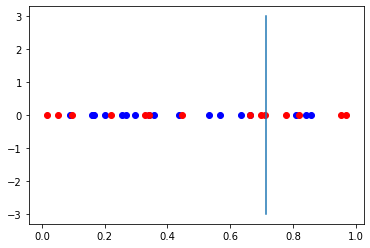

In [97]:
plt.scatter(X[torch.where(y > 0)[0]], torch.zeros_like(X[torch.where(y > 0)[0]]), c="blue")
plt.scatter(X[torch.where(y < 1)[0]], torch.zeros_like(X[torch.where(y < 1)[0]]), c="red")
plt.plot(search_space[best_acc_idx]*torch.ones_like(yy), yy)

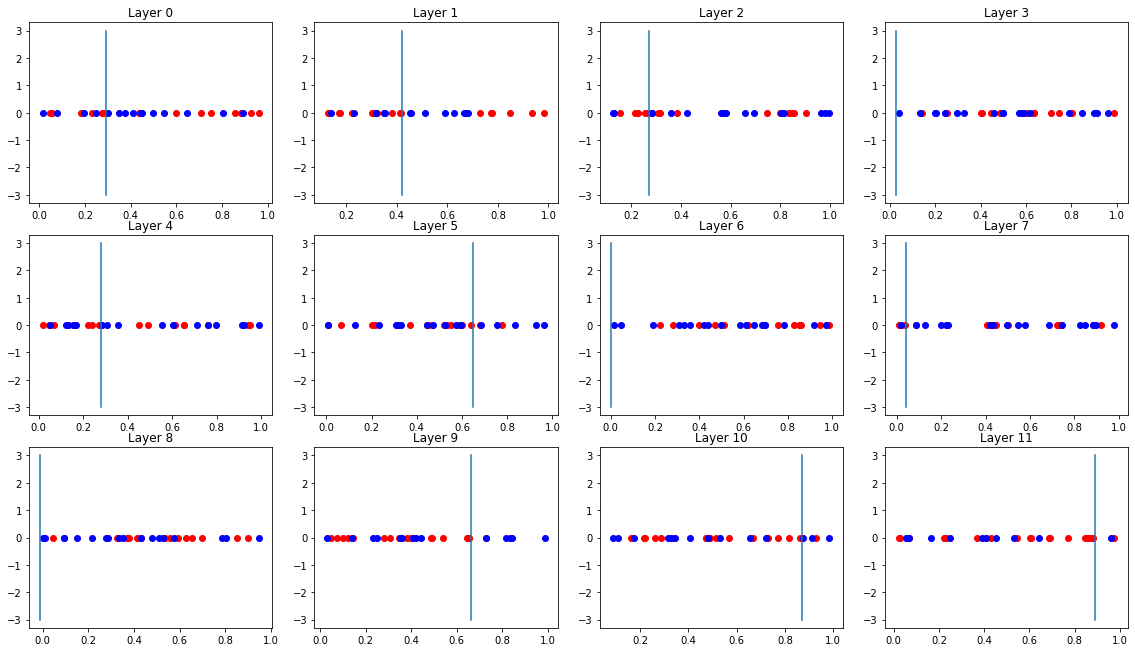

In [107]:
optimal_point = []
fig, axs = plt.subplots(3, 4, figsize=(16, 9))
fig.tight_layout()
for i in range(0, 12):
    X = data[i][:, 0]
    y = data[i][:, 1]
    
    search_space = torch.linspace(np.round(X.min().numpy() - 0.01, 2), np.round(X.max().numpy() + 0.01, 2), 100)
    best_acc = 0
    best_acc_idx = 0
    for j, threshold in enumerate(search_space):
        predict = (X < threshold).long()
        if accuracy(predict, y) > best_acc:
            best_acc = accuracy(predict, y)
            best_acc_idx = j
    
    x_min, x_max = torch.floor(X.min()), torch.ceil(X.max())
    y_min, y_max = -3, 3
    yy = torch.linspace(y_min, y_max, 3)
    
    axs[int(i/4), i%4].set_title(f'Layer {i}')
    axs[int(i/4), i%4].scatter(X[torch.where(y > 0)[0]], torch.zeros_like(X[torch.where(y > 0)[0]]), c="red")
    axs[int(i/4), i%4].scatter(X[torch.where(y < 1)[0]], torch.zeros_like(X[torch.where(y < 1)[0]]), c="blue")
    axs[int(i/4), i%4].plot(search_space[best_acc_idx]*torch.ones_like(yy), yy)